# Resolution of the optimisation problem

This notebook will help solve the following optimisation problem : 
TODO

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)


PROJECT_ROOT = c:\Users\Nicolas\Desktop\ECOLE\3A\Projet Avencore\avencore_hydrogen_production-Marie


## 1. Imports initiaux

In [2]:
import pyomo.environ as pyo

from Data.loading import load_prices
from Battery.battery_simulation import BatteryParams, BatteryBlock
from Electrolyser.electrolyser_simulation import ElectrolyserParams, ElectrolyserBlock, PowerBalanceBlock
from Costs.cost_functions import EconomicParams, ObjectiveBuilder

## 2. Loading the dataset

192840   2024-01-01 00:00:00
192841   2024-01-01 01:00:00
192842   2024-01-01 02:00:00
192843   2024-01-01 03:00:00
192844   2024-01-01 04:00:00
192845   2024-01-01 05:00:00
192846   2024-01-01 06:00:00
192847   2024-01-01 07:00:00
192848   2024-01-01 08:00:00
192849   2024-01-01 09:00:00
192850   2024-01-01 10:00:00
192851   2024-01-01 11:00:00
192852   2024-01-01 12:00:00
192853   2024-01-01 13:00:00
192854   2024-01-01 14:00:00
192855   2024-01-01 15:00:00
192856   2024-01-01 16:00:00
192857   2024-01-01 17:00:00
192858   2024-01-01 18:00:00
192859   2024-01-01 19:00:00
192860   2024-01-01 20:00:00
192861   2024-01-01 21:00:00
192862   2024-01-01 22:00:00
192863   2024-01-01 23:00:00
192864   2024-01-02 00:00:00
192865   2024-01-02 01:00:00
192866   2024-01-02 02:00:00
192867   2024-01-02 03:00:00
192868   2024-01-02 04:00:00
192869   2024-01-02 05:00:00
192870   2024-01-02 06:00:00
192871   2024-01-02 07:00:00
192872   2024-01-02 08:00:00
192873   2024-01-02 09:00:00
192874   2024-

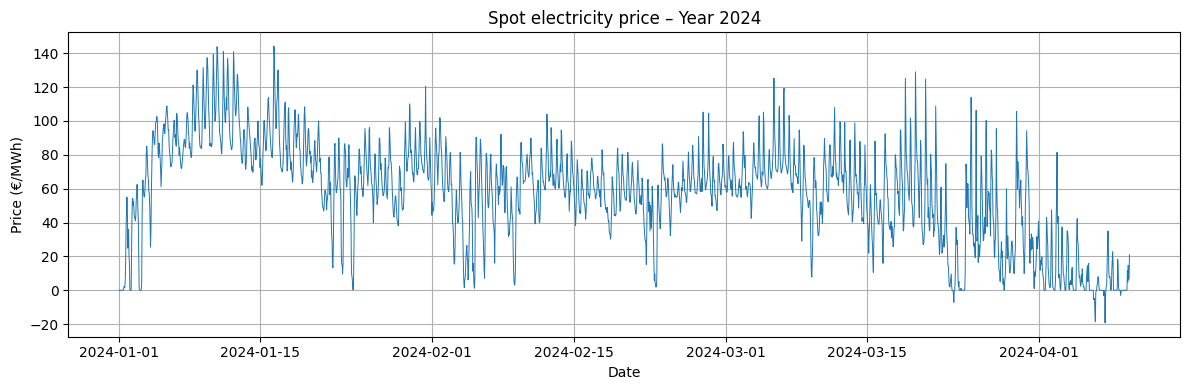

In [4]:
PATH_SPOT = "../Data/prix_spot.csv"
ELEC_PRICE, CO2_INTENSITY, T, df_2024 = load_prices(PATH_SPOT, year=2024)

print(df_2024['Date'][:48])

num_days = 10
N = num_days * 24

plt.figure(figsize=(12, 4))
plt.plot(df_2024['Date'][:2400], df_2024['Spot'][:2400], linewidth=0.7)

plt.title("Spot electricity price – Year 2024")
plt.xlabel("Date")
plt.ylabel("Price (€/MWh)")
plt.grid(True)

plt.tight_layout()
plt.show()

## 3. Global parameters

In [ ]:
dt = 1.0
ECON_PARA = EconomicParams(
    CAPEX_PWR_BAT = 150.0,
    CAPEX_EN_BAT = 10_000.0,
    FORWARD_PRICE = 75.0,
    CO2_COST = 80.0
)

ELECTRO_PARA = ElectrolyserParams(
    PWR_H2_MAX = 100.0,
    U_ELECTRO_MIN = 0.10,
    U_ELECTRO_MAX = 0.95,
    RAMP_ELECTRO = 1.0,
    ELECTRO_YIELD = 0.70,
    LHV_H2 = 55.0,
    dt = dt,
    H2_TARGET = 1_000_000.0
)

BAT_PARA = BatteryParams(
    CHARGE_YIELD = 1.0,
    DISCHARGE_YIELD = 1.0,
    dt = dt,
    SOC_MIN = 0.10,
    SOC_MAX = 0.95
)

## 4. Pyomo model definition

In [ ]:
m = pyo.ConcreteModel()
m.T = pyo.RangeSet(0, T-1)

# Dimension variables
m.PWR_BAT_MAX = pyo.Var(domain=pyo.NonNegativeReals) # MW
m.EN_BAT_MAX = pyo.Var(domain=pyo.NonNegativeReals) # MWh

## 5. Adding the different blocs

In [ ]:
# Battery
bat = BatteryBlock(m, m.T, BAT_PARA)
bat.add_variables()
bat.add_constraints()

# PEM Electrolyser
el = ElectrolyserBlock(m, m.T, ELECTRO_PARA)
el.add_variables()
el.add_constraints()

# Power balance
pb = PowerBalanceBlock(m, m.T, PWR_H2_MAX=ELECTRO_PARA.PWR_H2_MAX, PHI_BOUNDS=(0.0,1.0))
pb.add_variables()
pb.add_constraints()

## 6. Objective definition and solving

In [ ]:
objb = ObjectiveBuilder(m, m.T, ECON_PARA, ELEC_PRICE=ELEC_PRICE, CO2_INTENSITY=CO2_INTENSITY, dt=dt, include_co2=False)
objb.build_objective()

solver = pyo.SolverFactory("highs")
res = solver.solve(m, tee=True)
print(res.solver.status, res.solver.termination_condition)

Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 34560 rows; 20739 cols; 82940 nonzeros
Coefficient ranges:
  Matrix  [1e-01, 1e+02]
  Cost    [1e-02, 3e+05]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 1e+06]
Presolving model
24191 rows, 17282 cols, 69114 nonzeros  0s
Dependent equations search running on 4878 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
22156 rows, 15249 cols, 74936 nonzeros  0s
Presolve reductions: rows 22156(-12404); columns 15249(-5490); nonzeros 74936(-8004) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -6.0153876423e+01 Ph1: 160(1314); Du: 160(60.1539) 0s
      10389     4.7107457089e+04 Pr: 0(0) 3s

Performed postsolve
Solving the original LP from the solution after postsolve

Model status        : Optimal
Simplex   iterations: 10389
Objective valu

## 7. Results

In [ ]:
MEAN_H2_PWR = sum(pyo.value(m.PWR_H2[t]) for t in m.T) / T
TOT_H2_PWR = sum(pyo.value(m.PWR_H2[t]) for t in m.T)
H2_TOT_PROD  = sum(pyo.value(m.H2[t]) for t in m.T)
COST_OPTI = pyo.value(m.Obj)
MEAN_COST = (sum(ECON_PARA.FORWARD_PRICE * pyo.value(m.PHI) * dt + ELEC_PRICE[t] * pyo.value(m.PWR_SPOT[t]) * dt for t in m.T) / max(TOT_H2_PWR, 1e-9))
LCOH_OPTI = COST_OPTI / max(H2_TOT_PROD, 1e-9)

print("Electrolyser max power (MW):", f"{ELECTRO_PARA.PWR_H2_MAX:.2f}")
print("Optimal battery power (MW):", f"{pyo.value(m.PWR_BAT_MAX):.2f}")
print("Optimal battery capacity (MWh):", f"{pyo.value(m.EN_BAT_MAX):.2f}")
print("Optimal percentage forward (%):", f"{pyo.value(m.PHI)*100:.2f}")
print("Mean power electrolyser (MW):", f"{MEAN_H2_PWR:.2f}")
print("Total H2 production (kg):", f"{H2_TOT_PROD:.2f}")
print("Total cost (€):", f"{COST_OPTI:.2f}")
print("LCOH (€/kg):", f"{LCOH_OPTI:.2f}")

Electrolyser max power (MW): 100.00
Optimal battery power (MW): 1.00
Optimal battery capacity (MWh): 1.18
Optimal percentage forward (%): 22.07
Mean power electrolyser (MW): 22.73
Total H2 production (kg): 1000000.00
Total cost (€): 47107.46
LCOH (€/kg): 0.05
